In [1]:
import sys

from src.models import optimal_model_builder
from src.utils import augmentation_random_cut

PWD = '../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

from src.plot_utils import plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, _get_gauss_stats, plot_difference_hist

In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [4]:
all_X, all_y = all_channels_data[17][0], all_channels_data[17][1]

all_X.shape, all_y.shape

((19594, 64), (19594,))

# Preprocess

In [5]:
n_baseline = 20

In [6]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

X_aug, y_aug = augmentation_random_cut(all_X, all_y, 16, seed=42, apply=True)

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15675, 48), (3919, 48), (15675,), (3919,))

# Utils

In [7]:
def train_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, lr=0.01, name='model',
                train=False, n_epochs=3000, verbose=1, batch_size=2048, lr_patience=10, es_patience=200,
                loss_weights=10_000):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_data_dir = f'/data/model_weights/nn_results/smearing_48/{name}'
    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=PWD + model_data_dir + "/weights", save_best_only=True,
                                                     save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience, min_delta=0.01))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience=lr_patience))

    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size,
                            validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(PWD + model_data_dir + '/loss_log.csv')

    model.load_weights(PWD + model_data_dir + "/weights")
    history = pd.read_csv(PWD + model_data_dir + '/loss_log.csv')

    return history

# CFD

In [8]:
cfd = CFD(n_baseline=10, fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))

y_pred = np.array(y_pred)
y_pred.shape

(3919,)

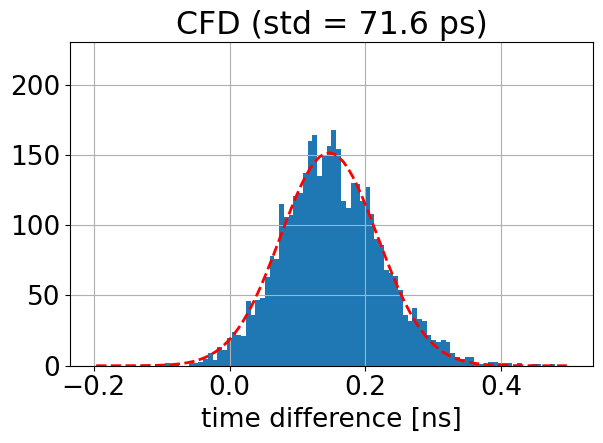

Covariance matrix of the Gaussian fit:
[[ 4.24964996e+00  4.46419516e-11 -1.33961681e-03]
 [ 4.46419516e-11  1.26686190e-06 -2.07378895e-14]
 [-1.33961681e-03 -2.07378895e-14  1.26686190e-06]]


In [9]:
std_cfd = plot_difference_hist(y_test * TIME_STEP, y_pred * TIME_STEP, 17, hist_range=(-0.2, 0.5), fontsize=19,
                               xlabel='time difference [ns]', title_text="CFD (std = 71.6 ps)", save_title=True,
                               savefig=PWD + '/data/plots/nn_results/smearing_48/CFD_diff.pdf', ymax=230)

# Optimal model

In [10]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

In [11]:
model = optimal_model_builder()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 48, 1)        0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 1)       4           ['reshape[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 48, 64)       192         ['batch_normalization[0][0]']

In [12]:
history = train_model(model, y_train=Y_heatmap_train, y_test=Y_heatmap_test, name='optimal', loss_weights=10_000,
                      train=False)

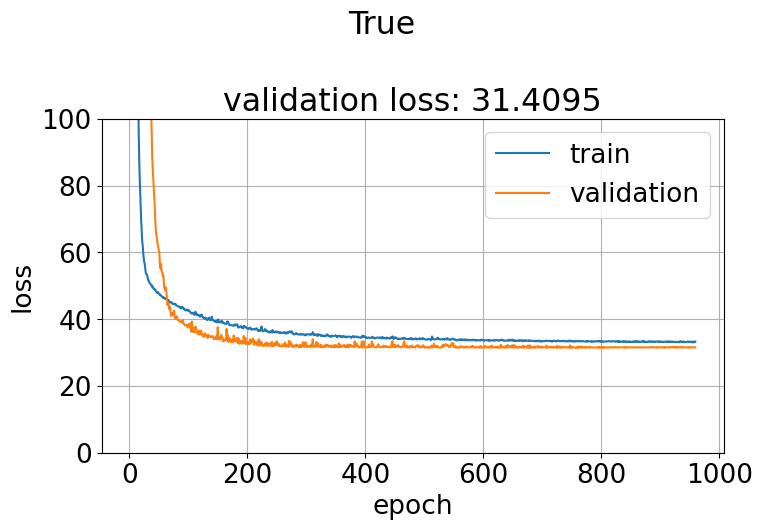

In [13]:
plot_history(history, ymax=100, savefig=PWD + '/data/plots/nn_results/smearing_48/optimal_model_training_curve.pdf',
             title=True, plt_font_size=19)

In [14]:
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    y_pred[i] = _get_gauss_stats(y, std_0=0.8)

123/123 [==============================] - 2s 3ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


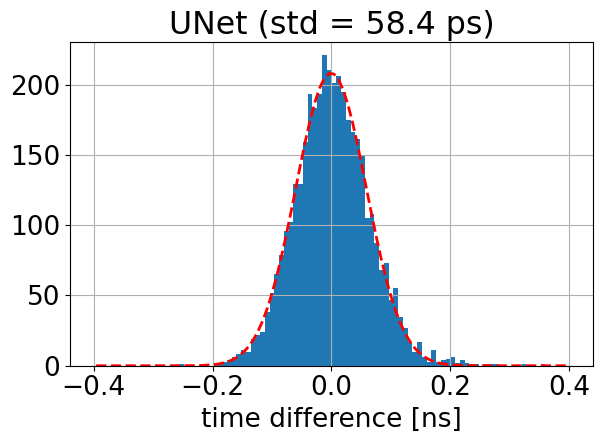

Covariance matrix of the Gaussian fit:
[[ 2.78454812e+00 -6.41125194e-11 -5.30721415e-04]
 [-6.41125194e-11  3.03458471e-07  3.51230121e-14]
 [-5.30721415e-04  3.51230121e-14  3.03458815e-07]]


In [15]:
std_model = plot_difference_hist(y_test * TIME_STEP, y_pred * TIME_STEP, 17, hist_range=(-0.4, 0.4), fontsize=19,
                                 xlabel='time difference [ns]', title_text="UNet (std = 58.4 ps)", save_title=True,
                                 savefig=PWD + '/data/plots/nn_results/smearing_48/model_diff.pdf', ymax=230)

# Compare

In [16]:
print(f"{'CFD':>20}: {std_cfd * 1000:6.2f} ps")
improv = (1 - std_model / std_cfd) * 100
print(f"{'Optimal NN model':>20}: {std_model * 1000:6.2f} ps (improvement: {improv:0.2f} %)")

                 CFD:  71.59 ps
    Optimal NN model:  59.42 ps (improvement: 17.00 %)
